In [1]:
# Set transformer cache to "./.transformer_cache"
import os
os.environ['TRANSFORMERS_CACHE'] = './cache'

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from transformers import TimeSeriesTransformerConfig, TimeSeriesTransformerModel, TimeSeriesTransformerForPrediction
from transformers import AdamW
from sklearn.metrics import roc_auc_score, f1_score
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

In [2]:
df = pd.read_csv("train_data_1h.csv")
df.head()

,admissionid,hour,creatinine,urine,measuredat,baseline_creatinine,temp,heart_rate,systolic_ABP,mean_ABP,...,hematocryt_change,lactate_change,sodium_change,ph_change,stage_2hours,AKI_2hours,icu_days,stage_1hours,AKI,AKI_1hours
0,9,0,103.0,120.0,0,94.0,32.4,79.0,130.0,92.0,...,0.000,0.0,0.0,0.00,0.0,0,0.000000,0.0,0,0.0
1,9,1,103.0,120.0,3600000,94.0,32.4,79.0,130.0,92.0,...,0.030,0.4,1.5,0.00,0.0,0,0.041667,0.0,0,0.0
2,9,2,103.0,120.0,7200000,94.0,32.4,79.0,130.0,92.0,...,-0.010,0.9,1.0,0.00,0.0,0,0.083333,0.0,0,0.0
3,9,3,103.0,120.0,10800000,94.0,32.4,79.0,130.0,92.0,...,0.075,0.0,3.0,0.00,0.0,0,0.125000,0.0,0,0.0
4,9,4,103.0,110.0,14400000,94.0,33.0,80.0,149.0,109.0,...,0.005,0.0,0.0,0.04,0.0,0,0.166667,0.0,0,0.0


In [3]:
test_df = pd.read_csv("test_data_1h.csv")

In [4]:
# Select the categorical features from the dataframe
categorical_features = df.select_dtypes(include=['object', 'bool'])

# Apply label encoder to the categorical features
label_encoder = LabelEncoder()
encoded_categorical_features = categorical_features.apply(label_encoder.fit_transform)

# Combine the encoded categorical features with the numerical features
numerical_features = df.select_dtypes(include=['float', 'int'])
encoded_dataset = pd.concat([numerical_features, encoded_categorical_features], axis=1)

# Apply label encoder to test
categorical_features_test = test_df.select_dtypes(include=['object', 'bool'])
encoded_categorical_features_test = categorical_features_test.apply(label_encoder.fit_transform)
numerical_features_test = test_df.select_dtypes(include=['float', 'int'])
encoded_dataset_test = pd.concat([numerical_features_test, encoded_categorical_features_test], axis=1)

In [9]:
# Initialize empty lists to store the results
average_length = []
average_count_0 = []
average_count_1 = []

# Iterate through the encoded_dataset
for admissionid, admissionid_df in encoded_dataset.groupby('admissionid'):
    # print(admissionid)
    # print(admissionid_df['AKI_6hours'].values)
    
    # Calculate the average length of AKI-6hours
    length = len(admissionid_df['AKI_1hours'].values)
    average_length.append(length)
    
    # Calculate the average count of 0s and 1s
    count_0 = np.count_nonzero(admissionid_df['AKI_1hours'].values == 0)
    count_1 = np.count_nonzero(admissionid_df['AKI_1hours'].values == 1)
    average_count_0.append(count_0)
    average_count_1.append(count_1)
    
# Calculate the overall averages
overall_average_length = np.mean(average_length)
overall_average_count_0 = np.mean(average_count_0)
overall_average_count_1 = np.mean(average_count_1)

# Print the results
print("Average Length of AKI-6hours:", overall_average_length)
print("Average Count of 0s:", overall_average_count_0)
print("Average Count of 1s:", overall_average_count_1)
print("Minimum Length of AKI-1hours:", np.min(average_length))
print("Maximum Length of AKI-1hours:", np.max(average_length))

# Use these counts to determine the context length and prediction length
# 24 context length, 8 prediction length, 4 lag sequence

Average Length of AKI-6hours: 310.863476163977
Average Count of 0s: 154.3989983305509
Average Count of 1s: 156.4644778334261
Minimum Length of AKI-1hours: 20
Maximum Length of AKI-1hours: 5581


In [6]:
def make_train_dataset(dataset, context_length, prediction_length, lag_length):
    # Initialize empty lists to store the dataset components
    all_past_values = []
    all_future_values = []
    all_past_time_features = []
    all_future_time_features = []
    all_past_values_mask = []

    features_columns = ['creatinine', 'urine', 'measuredat', 'temp', 'heart_rate', 'systolic_ABP', 'mean_ABP', 'dystolic_ABP', 'resp_rate', 'glucose', 'hema', 'calcium', 'kalium', 'ox_sat', 'thrombo', 'bilirubine', 'leukocyten', 'hematocryt', 'lactate', 'sodium', 'ph']
    temporal_columns = ['creatinine_change', 'urine_change', 'temp_change', 'heart_rate_change', 'systolic_ABP_change', 'mean_ABP_change', 'dystolic_ABP_change', 'resp_rate_change', 'glucose_change', 'hema_change', 'calcium_change', 'kalium_change', 'ox_sat_change', 'thrombo_change', 'bilirubine_change', 'leukocyten_change', 'hematocryt_change', 'lactate_change', 'sodium_change', 'ph_change']
    extra_features = ['has_sepsis', 'has_ventilation', 'nsaid_taken', 'vassopressor_taken', 'acei_taken', 'arb_taken', 'cardiac_surgery', 'traumatology', 'vascular_surgery', 'gastroenterology_surgery', 'lungs_oncology_surgery', 'oncology_surgery', 'neuro_surgery', 'gender_Man', 'gender_Vrouw', 'agegroup', 'weightgroup', 'heightgroup']

    # Iterate over admission IDs
    for admission_id in dataset['admissionid'].unique():
        # Get the sample for the current admission ID
        sample_patient = dataset[dataset['admissionid'] == admission_id].copy()

        # Check if the sample patient has enough AKI_6hours values
        if len(sample_patient['AKI_1hours']) >= context_length + lag_length + prediction_length:
            # Split the dataframe into the required components
            past_values = sample_patient['AKI_1hours'].values[:context_length + lag_length]
            future_values = sample_patient['AKI_1hours'].values[context_length + lag_length:context_length + lag_length + prediction_length]
            sample_patient.drop(columns=['admissionid', 'patientid', 'admissionyeargroup', 'comparison_result', 'stage_2hours', 'AKI_2hours', 'stage_1hours', 'AKI', 'has_aki', 'AKI_1hours'], inplace=True)
            past_time_features = sample_patient[features_columns + extra_features].values[:context_length + lag_length]
            future_time_features = sample_patient[features_columns + extra_features].values[context_length + lag_length:context_length + lag_length + prediction_length]
            past_values_mask = np.ones(context_length)
            
            # Append the components to the respective lists
            all_past_values.append(past_values)
            all_future_values.append(future_values)
            all_past_time_features.append(past_time_features)
            all_future_time_features.append(future_time_features)
            all_past_values_mask.append(past_values_mask)

    # Convert the lists to tensors
    all_past_values_tensor = torch.tensor(all_past_values, dtype=torch.float32)
    all_future_values_tensor = torch.tensor(all_future_values, dtype=torch.float32)
    all_past_time_features_tensor = torch.tensor(all_past_time_features, dtype=torch.float32)
    all_future_time_features_tensor = torch.tensor(all_future_time_features, dtype=torch.float32)
    all_past_values_mask_tensor = torch.tensor(all_past_values_mask, dtype=torch.float32)

        # Print the shapes of the tensors
    print("All Past Values Tensor Shape:", all_past_values_tensor.shape)
    print("All Future Values Tensor Shape:", all_future_values_tensor.shape)
    print("All Past Time Features Tensor Shape:", all_past_time_features_tensor.shape)
    print("All Future Time Features Tensor Shape:", all_future_time_features_tensor.shape)

    return {"past_values": all_past_values_tensor, "future_values":  all_future_values_tensor, "past_features": all_past_time_features_tensor, "future_features": all_future_time_features_tensor, "past_values_mask": all_past_values_mask_tensor}

In [ ]:
features_columns = ['creatinine', 'urine', 'measuredat', 'temp', 'heart_rate', 'systolic_ABP', 'mean_ABP', 'dystolic_ABP', 'resp_rate', 'glucose', 'hema', 'calcium', 'kalium', 'ox_sat', 'thrombo', 'bilirubine', 'leukocyten', 'hematocryt', 'lactate', 'sodium', 'ph', 'creatinine_change', 'urine_change', 'temp_change', 'heart_rate_change', 'systolic_ABP_change', 'mean_ABP_change', 'dystolic_ABP_change', 'resp_rate_change', 'glucose_change', 'hema_change', 'calcium_change', 'kalium_change', 'ox_sat_change', 'thrombo_change', 'bilirubine_change', 'leukocyten_change', 'hematocryt_change', 'lactate_change', 'sodium_change', 'ph_change']
len(features_columns)

41

In [ ]:
extra_features = ['has_sepsis', 'has_ventilation', 'nsaid_taken', 'vassopressor_taken', 'antimicrobiotic_taken', 'acei_taken', 'arb_taken', 'cardiac_surgery', 'traumatology', 'vascular_surgery', 'gastroenterology_surgery', 'lungs_oncology_surgery', 'oncology_surgery', 'neuro_surgery', 'gender_Man', 'gender_Vrouw', 'agegroup', 'weightgroup', 'heightgroup', 'Death']
len(extra_features)

20

In [7]:
context_length = 192
prediction_length = 36
lag_length = 24
train_data = make_train_dataset(encoded_dataset, context_length, prediction_length, lag_length)
test_data = make_train_dataset(encoded_dataset_test, context_length, prediction_length, lag_length)

C:\Users\dheer\AppData\Local\Temp\ipykernel_7744\2017474585.py:36: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_new.cpp:248.)
  all_past_values_tensor = torch.tensor(all_past_values, dtype=torch.float32)


All Past Values Tensor Shape: torch.Size([2128, 216])
All Future Values Tensor Shape: torch.Size([2128, 36])
All Past Time Features Tensor Shape: torch.Size([2128, 216, 39])
All Future Time Features Tensor Shape: torch.Size([2128, 36, 39])
All Past Values Tensor Shape: torch.Size([256, 216])
All Future Values Tensor Shape: torch.Size([256, 36])
All Past Time Features Tensor Shape: torch.Size([256, 216, 39])
All Future Time Features Tensor Shape: torch.Size([256, 36, 39])


In [8]:
# Create a TensorDataset
train_dataset = TensorDataset(train_data["past_values"], train_data["future_values"], train_data["past_features"], train_data["future_features"], train_data["past_values_mask"])
test_dataset = TensorDataset(test_data["past_values"], test_data["future_values"], test_data["past_features"], test_data["future_features"], test_data["past_values_mask"])

# Create a DataLoader
batch_size = 16
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

In [9]:
# Initializing a default Time Series Transformer configuration
configuration = TimeSeriesTransformerConfig(context_length=context_length, lags_sequence=[1, 2, 4, 6, 12, 24], prediction_length=prediction_length, num_time_features=39,
                                            encoder_layers=4, decoder_layers=4, encoder_attention_heads=2, decoder_attention_heads=4,
                                            d_model=128, encoder_ffn_dim=512, decoder_ffn_dim=512,

)

# Randomly initializing a model (with random weights) from the configuration
model = TimeSeriesTransformerForPrediction(configuration)

# Accessing the model configuration
configuration = model.config
print(configuration)

TimeSeriesTransformerConfig {
  "activation_dropout": 0.1,
  "activation_function": "gelu",
  "attention_dropout": 0.1,
  "cardinality": [
    0
  ],
  "context_length": 192,
  "d_model": 128,
  "decoder_attention_heads": 4,
  "decoder_ffn_dim": 512,
  "decoder_layerdrop": 0.1,
  "decoder_layers": 4,
  "distribution_output": "student_t",
  "dropout": 0.1,
  "embedding_dimension": [
    0
  ],
  "encoder_attention_heads": 2,
  "encoder_ffn_dim": 512,
  "encoder_layerdrop": 0.1,
  "encoder_layers": 4,
  "feature_size": 47,
  "init_std": 0.02,
  "input_size": 1,
  "is_encoder_decoder": true,
  "lags_sequence": [
    1,
    2,
    4,
    6,
    12,
    24
  ],
  "loss": "nll",
  "model_type": "time_series_transformer",
  "num_dynamic_real_features": 0,
  "num_parallel_samples": 100,
  "num_static_categorical_features": 0,
  "num_static_real_features": 0,
  "num_time_features": 39,
  "prediction_length": 36,
  "scaling": "mean",
  "transformers_version": "4.34.0",
  "use_cache": true
}



In [ ]:
# Save the config file
configuration.save_pretrained('1h_model_config_initial')

In [10]:
# print count of parameters in the model
print("Number of parameters:", model.num_parameters())
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total trainable parameters:", total_params)

Number of parameters: 1922691
Total trainable parameters: 1864323


In [11]:
num_epochs = 10
learning_rate = 1e-3
optimizer = AdamW(model.parameters(), lr=learning_rate)


# Training loop
for epoch in range(num_epochs):
    running_loss = 0.0
    total_batches = len(train_dataloader)

    # Iterate over the batches
    for batch_idx, batch in enumerate(train_dataloader):
        past_values_batch, future_values_batch, past_time_features_batch, future_time_features_batch, past_values_mask_batch = batch
        
        # # Zero the gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(
            past_values=past_values_batch,
            past_time_features=past_time_features_batch,
            past_observed_mask=past_values_mask_batch,
            future_values=future_values_batch,
            future_time_features=future_time_features_batch,
        )
        loss = outputs.loss
        loss.backward()
        
        # Update the weights
        optimizer.step()
        
        # Accumulate the loss
        running_loss += loss.item()

        # Print batch loss
        # print(f"Epoch {epoch+1}/{num_epochs}, Batch {batch_idx+1}/{total_batches}, Loss: {loss.item():.4f}")
    
    # Print the average loss for the epoch
    average_loss = running_loss / total_batches
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {average_loss:.4f}")

d:\Documents\Vrije\DL2\DL2\lib\site-packages\transformers\optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/10, Loss: -9.3362
Epoch 2/10, Loss: -9.3729
Epoch 3/10, Loss: -9.3918
Epoch 4/10, Loss: -9.4040
Epoch 5/10, Loss: -9.4094
Epoch 6/10, Loss: -9.3992
Epoch 7/10, Loss: -9.3481
Epoch 8/10, Loss: -9.3380
Epoch 9/10, Loss: -9.3669
Epoch 10/10, Loss: -9.3622


In [12]:
all_targets = []
all_predictions = []

for batch_idx, batch in enumerate(test_dataloader):
    past_values_batch, future_values_batch, past_time_features_batch, future_time_features_batch, past_values_mask_batch = batch
    outputs = model.generate(
        past_values=past_values_batch,
        past_time_features=past_time_features_batch,
        past_observed_mask=past_values_mask_batch,
        future_time_features=future_time_features_batch,
    )

    mean_prediction = outputs.sequences.mean(dim=1)

    # Round the predictions to nearest integer
    predictions = torch.round(mean_prediction)
    targets = future_values_batch

    # Append predictions and targets to lists
    all_predictions.append(predictions)
    all_targets.append(targets)

    # print progress
    print(f"Batch {batch_idx+1}/{len(test_dataloader)}")

# Concatenate the predictions and targets tensors
all_predictions = torch.cat(all_predictions, dim=0)
all_targets = torch.cat(all_targets, dim=0)

# Convert other predictions to 0 and 1
all_predictions[all_predictions > 1] = 1
all_predictions[all_predictions < 0] = 0

# Calculate AUC and F1 score
auc = roc_auc_score(all_targets.cpu().numpy(), all_predictions.cpu().numpy())
f1 = f1_score(all_targets.cpu().numpy(), all_predictions.cpu().numpy(), average='weighted')

# Print the AUC and F1 score
print(f"AUC: {auc:.4f}, F1 Score: {f1:.4f}")

AUC: 0.6139, F1 Score: 0.3694


In [35]:
# Get the unique values and their counts 
unique, counts = np.unique(all_predictions.cpu().numpy(), return_counts=True)
print("Unique values:", unique)
print("Counts:", counts)

unique, counts = np.unique(all_targets.cpu().numpy(), return_counts=True)
print("Unique values:", unique)
print("Counts:", counts)

# print length of both
print(len(all_predictions))
print(len(all_targets))

Unique values: [0. 1.]
Counts: [15611  2289]
Unique values: [0. 1.]
Counts: [8734 9166]
179
179


In [31]:
auc = roc_auc_score(all_targets.cpu().numpy(), all_predictions.cpu().numpy())
f1 = f1_score(all_targets.cpu().numpy(), all_predictions.cpu().numpy(), average='weighted')

# Print the AUC and F1 score
print(f"AUC: {auc:.4f}, F1 Score: {f1:.4f}")

AUC: 0.6249, F1 Score: 0.3972


In [32]:
# Save the model
save_path = "models/model_1h_192Context_36Prediction"
model.save_pretrained(save_path)

Trying without temporal features

In [57]:
train_data_noExtra = make_train_dataset(encoded_dataset, context_length, prediction_length, lag_length)
test_data_noExtra = make_train_dataset(encoded_dataset_test, context_length, prediction_length, lag_length)

All Past Values Tensor Shape: torch.Size([2300, 70])
All Future Values Tensor Shape: torch.Size([2300, 12])
All Past Time Features Tensor Shape: torch.Size([2300, 70, 41])
All Future Time Features Tensor Shape: torch.Size([2300, 12, 41])
All Past Values Tensor Shape: torch.Size([188, 70])
All Future Values Tensor Shape: torch.Size([188, 12])
All Past Time Features Tensor Shape: torch.Size([188, 70, 41])
All Future Time Features Tensor Shape: torch.Size([188, 12, 41])


In [62]:
# Create a TensorDataset
train_dataset_noExtra = TensorDataset(train_data_noExtra["past_values"], train_data_noExtra["future_values"], train_data_noExtra["past_features"], train_data_noExtra["future_features"], train_data_noExtra["past_values_mask"])
test_dataset_noExtra = TensorDataset(test_data_noExtra["past_values"], test_data_noExtra["future_values"], test_data_noExtra["past_features"], test_data_noExtra["future_features"], test_data_noExtra["past_values_mask"])

# Create a DataLoader
batch_size = 16
train_dataloader_noExtra = DataLoader(train_dataset_noExtra, batch_size=batch_size, shuffle=True)
test_dataloader_noExtra = DataLoader(test_dataset_noExtra, batch_size=batch_size)

In [64]:
# Initializing a default Time Series Transformer configuration
configuration2 = TimeSeriesTransformerConfig(context_length=context_length, lags_sequence=[1, 2, 4, 6], prediction_length=prediction_length, num_time_features=41,
                                            encoder_layers=4, decoder_layers=4, encoder_attention_heads=2, decoder_attention_heads=4,
                                            d_model=128, encoder_ffn_dim=512, decoder_ffn_dim=512,

)

# Randomly initializing a model (with random weights) from the configuration
model2 = TimeSeriesTransformerForPrediction(configuration2)

# Accessing the model configuration
# configuration = model.config
print(configuration2)

TimeSeriesTransformerConfig {
  "activation_dropout": 0.1,
  "activation_function": "gelu",
  "attention_dropout": 0.1,
  "cardinality": [
    0
  ],
  "context_length": 64,
  "d_model": 128,
  "decoder_attention_heads": 4,
  "decoder_ffn_dim": 512,
  "decoder_layerdrop": 0.1,
  "decoder_layers": 4,
  "distribution_output": "student_t",
  "dropout": 0.1,
  "embedding_dimension": [
    0
  ],
  "encoder_attention_heads": 2,
  "encoder_ffn_dim": 512,
  "encoder_layerdrop": 0.1,
  "encoder_layers": 4,
  "feature_size": 47,
  "init_std": 0.02,
  "input_size": 1,
  "is_encoder_decoder": true,
  "lags_sequence": [
    1,
    2,
    4,
    6
  ],
  "loss": "nll",
  "model_type": "time_series_transformer",
  "num_dynamic_real_features": 0,
  "num_parallel_samples": 100,
  "num_static_categorical_features": 0,
  "num_static_real_features": 0,
  "num_time_features": 41,
  "prediction_length": 12,
  "scaling": "mean",
  "transformers_version": "4.34.0",
  "use_cache": true
}



In [65]:
num_epochs = 10
learning_rate = 1e-3
optimizer = AdamW(model2.parameters(), lr=learning_rate)


# Training loop
for epoch in range(num_epochs):
    running_loss = 0.0
    total_batches = len(train_dataloader_noExtra)

    # Iterate over the batches
    for batch_idx, batch in enumerate(train_dataloader_noExtra):
        past_values_batch, future_values_batch, past_time_features_batch, future_time_features_batch, past_values_mask_batch = batch
        
        # # Zero the gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model2(
            past_values=past_values_batch,
            past_time_features=past_time_features_batch,
            past_observed_mask=past_values_mask_batch,
            future_values=future_values_batch,
            future_time_features=future_time_features_batch,
        )
        loss = outputs.loss
        loss.backward()
        
        # Update the weights
        optimizer.step()
        
        # Accumulate the loss
        running_loss += loss.item()

        # Print batch loss
        # print(f"Epoch {epoch+1}/{num_epochs}, Batch {batch_idx+1}/{total_batches}, Loss: {loss.item():.4f}")
    
    # Print the average loss for the epoch
    average_loss = running_loss / total_batches
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {average_loss:.4f}")

d:\Documents\Vrije\DL2\DL2\lib\site-packages\transformers\optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/10, Loss: -9.9325
Epoch 2/10, Loss: -10.0055
Epoch 3/10, Loss: -10.0194
Epoch 4/10, Loss: -10.0422
Epoch 5/10, Loss: -10.0353
Epoch 6/10, Loss: -10.0474
Epoch 7/10, Loss: -10.0382
Epoch 8/10, Loss: -10.0501
Epoch 9/10, Loss: -10.0505
Epoch 10/10, Loss: -10.0564


In [66]:
all_targets = []
all_predictions = []

for batch_idx, batch in enumerate(test_dataloader_noExtra):
    past_values_batch, future_values_batch, past_time_features_batch, future_time_features_batch, past_values_mask_batch = batch
    outputs = model2.generate(
        past_values=past_values_batch,
        past_time_features=past_time_features_batch,
        past_observed_mask=past_values_mask_batch,
        future_time_features=future_time_features_batch,
    )

    mean_prediction = outputs.sequences.mean(dim=1)

    # Round the predictions to nearest integer
    predictions = torch.round(mean_prediction)
    targets = future_values_batch

    # Append predictions and targets to lists
    all_predictions.append(predictions)
    all_targets.append(targets)

# Concatenate the predictions and targets tensors
all_predictions = torch.cat(all_predictions, dim=0)
all_targets = torch.cat(all_targets, dim=0)

# Calculate AUC and F1 score
auc = roc_auc_score(all_targets.cpu().numpy(), all_predictions.cpu().numpy())
f1 = f1_score(all_targets.cpu().numpy(), all_predictions.cpu().numpy(), average='weighted')

# Print the AUC and F1 score
print(f"AUC: {auc:.4f}, F1 Score: {f1:.4f}")

AUC: 0.6717, F1 Score: 0.5103


Running lstm

In [7]:
def make_rnn_dataset(dataset, lookback, test=False):
    # Initialize empty lists to store the dataset components
    all_features = []
    all_targets = []
    features_columns = ['creatinine', 'urine', 'measuredat', 'temp', 'heart_rate', 'systolic_ABP', 'mean_ABP', 'dystolic_ABP', 'resp_rate', 'glucose', 'hema', 'calcium', 'kalium', 'ox_sat', 'thrombo', 'bilirubine', 'leukocyten', 'hematocryt', 'lactate', 'sodium', 'ph']
    temporal_columns = ['creatinine_change', 'urine_change', 'temp_change', 'heart_rate_change', 'systolic_ABP_change', 'mean_ABP_change', 'dystolic_ABP_change', 'resp_rate_change', 'glucose_change', 'hema_change', 'calcium_change', 'kalium_change', 'ox_sat_change', 'thrombo_change', 'bilirubine_change', 'leukocyten_change', 'hematocryt_change', 'lactate_change', 'sodium_change', 'ph_change']
    extra_features = ['has_sepsis', 'has_ventilation', 'nsaid_taken', 'vassopressor_taken', 'acei_taken', 'arb_taken', 'cardiac_surgery', 'traumatology', 'vascular_surgery', 'gastroenterology_surgery', 'lungs_oncology_surgery', 'oncology_surgery', 'neuro_surgery', 'gender_Man', 'gender_Vrouw', 'agegroup', 'weightgroup', 'heightgroup']
    threshold = 0.3

    # Iterate over admission IDs
    for admission_id in dataset['admissionid'].unique():
        # Get the sample for the current admission ID
        sample_patient = dataset[dataset['admissionid'] == admission_id].copy()
        counter = 0
        for i in range(len(sample_patient['AKI_1hours'])-lookback):
            if counter >= 15:
                break
            feature = sample_patient[features_columns + extra_features].values[i:i+lookback]
            target = sample_patient['AKI_1hours'].values[i+1:i+lookback+1]
            
            ratio = target.sum() / len(target)
            # Check if the ratio is within the threshold range
            if not test and threshold <= ratio <= 1 - threshold:
                # Append the features and the target to the lists
                all_features.append(feature)
                all_targets.append(target)
            if test:
                all_features.append(feature)
                all_targets.append(target)
            counter += 1

    # Convert the lists to tensors
    all_features_tensor = torch.tensor(all_features, dtype=torch.float32)
    all_targets_tensor = torch.tensor(all_targets, dtype=torch.float32)
 
        # Print the shapes of the tensors
    print("All targets Tensor Shape:", all_targets_tensor.shape)
    print("All Features Tensor Shape:", all_features_tensor.shape)

    return all_features_tensor, all_targets_tensor

In [8]:
lstm_train_data = make_rnn_dataset(encoded_dataset, 10)
lstm_test_data = make_rnn_dataset(encoded_dataset_test, 10, test=True)

C:\Users\dheer\AppData\Local\Temp\ipykernel_28428\4044408156.py:33: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_new.cpp:248.)
  all_features_tensor = torch.tensor(all_features, dtype=torch.float32)


All targets Tensor Shape: torch.Size([3449, 10])
All Features Tensor Shape: torch.Size([3449, 10, 39])
All targets Tensor Shape: torch.Size([40082, 10])
All Features Tensor Shape: torch.Size([40082, 10, 39])


In [9]:
class AKIModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, bidirectional=False):
        super().__init__()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True, bidirectional=bidirectional)
        if bidirectional:
            hidden_size *= 2
        self.linear = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # x shape: (batch, sequence, features)
        output, _ = self.lstm(x)
        # output shape: (batch, sequence, hidden_size)
        output = self.linear(output)
        # output shape: (batch, sequence, output_size)
        output = torch.sigmoid(output)
        return output

In [10]:
input_size = 39
hidden_size = 50
num_layers = 4
output_size = 1

lstm_model = AKIModel(input_size, hidden_size, num_layers, output_size, bidirectional=False)

In [14]:
# import torch
# import torch.utils.data as data
# # load the model
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# lstm_model.load_state_dict(torch.load('models/lstm_model_1h'))
# lstm_model.to(device)
# test_loader = data.DataLoader(data.TensorDataset(lstm_test_data[0], lstm_test_data[1]), shuffle=False, batch_size=8, pin_memory=True)

d:\Documents\Vrije\DL2\DL2\lib\site-packages\transformers\optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 0: train loss 0.0820, test loss 0.0745
Epoch 5: train loss 0.0732, test loss 0.0721
Epoch 10: train loss 0.0729, test loss 0.0736
Epoch 15: train loss 0.0734, test loss 0.0720
Epoch 20: train loss 0.0728, test loss 0.0723
Epoch 25: train loss 0.0727, test loss 0.0722
Early stopping triggered. No improvement in validation loss for 5 epochs.


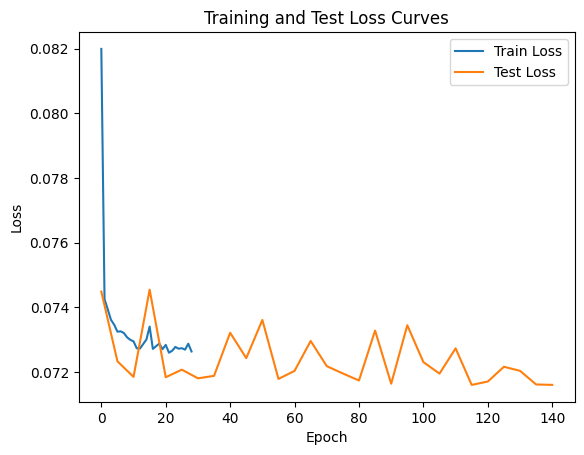

In [21]:
# Early stopping
import numpy as np
import torch
import torch.nn.functional as F
import torch.utils.data as data
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

num_epochs = 10
learning_rate = 1e-3
optimizer = AdamW(lstm_model.parameters(), lr=learning_rate)
loss_fn = F.mse_loss
loader = data.DataLoader(data.TensorDataset(lstm_train_data[0], lstm_train_data[1]), shuffle=True, batch_size=8, pin_memory=True)
test_loader = data.DataLoader(data.TensorDataset(lstm_test_data[0], lstm_test_data[1]), shuffle=False, batch_size=8, pin_memory=True)
lstm_model.to(device)

n_epochs = 30
train_losses = []
test_losses = []

best_val_loss = float('inf')
patience = 5  # Number of epochs to wait for improvement
early_stop_counter = 0

for epoch in range(n_epochs):
    lstm_model.train()
    train_loss = 0.0
    for X_batch, y_batch in loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        y_pred = lstm_model(X_batch)
        y_pred = y_pred.squeeze()
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * X_batch.size(0)
    train_loss /= len(loader.dataset)
    train_losses.append(train_loss)

    # Validation
    lstm_model.eval()
    with torch.no_grad():
        val_loss = 0.0
        for X_val, y_val in test_loader:
            X_val = X_val.to(device)
            y_val = y_val.to(device)
            y_pred = lstm_model(X_val)
            y_pred = y_pred.squeeze()
            loss = loss_fn(y_pred, y_val)
            val_loss += loss.item() * X_val.size(0)
        val_loss /= len(test_loader.dataset)
    test_losses.append(val_loss)

    if epoch % 5 == 0:
        print("Epoch %d: train loss %.4f, test loss %.4f" % (epoch, train_loss, val_loss))

    # Check for early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stop_counter = 0
    else:
        early_stop_counter += 1
        if early_stop_counter >= patience:
            print("Early stopping triggered. No improvement in validation loss for %d epochs." % patience)
            break

# Plot the training and test loss curves
plt.plot(range(len(train_losses)), train_losses, label='Train Loss')
plt.plot(range(0, len(test_losses) * 5, 5), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss Curves')
plt.legend()
plt.show()

In [15]:
lstm_all_targets = []
lstm_all_predictions = []

for batch_idx, batch in enumerate(test_loader):
    lstm_model.eval()
    with torch.no_grad():
        X_val, y_val = batch
        X_val = X_val.to(device)
        y_val = y_val.to(device)
        y_pred = lstm_model(X_val)
        y_pred = y_pred.squeeze()

    # Append predictions and targets to lists
    lstm_all_predictions.append(y_pred)
    lstm_all_targets.append(y_val)

# Concatenate the predictions and targets tensors
lstm_all_predictions = torch.cat(lstm_all_predictions, dim=0)
lstm_all_targets = torch.cat(lstm_all_targets, dim=0)

# Flatten the predictions and targets
y_true = lstm_all_targets.cpu().numpy().flatten()
y_pred = lstm_all_predictions.cpu().numpy().flatten()
threshold = 0.5  # Set the threshold for classification
y_pred_binary = np.where(y_pred >= threshold, 1, 0)

# Calculate AUC and F1 score
auc = roc_auc_score(y_true, y_pred_binary)
f1 = f1_score(y_true, y_pred_binary)

# Print the AUC and F1 score
print(f"AUC: {auc:.4f}, F1 Score: {f1:.4f}")

AUC: 0.5000, F1 Score: 0.0000


In [16]:
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, precision_score, recall_score

y_true = lstm_all_targets.cpu().numpy()
threshold = 0.5  # Set the threshold for classification
y_pred_binary = np.where(lstm_all_predictions.cpu() >= threshold, 1, 0)
# Convert y_true to int
y_true = y_true.astype(int)
# flatten y_true and y_pred_binary
y_true = y_true.flatten()
y_pred_binary = y_pred_binary.flatten()
confusion_mat = confusion_matrix(y_true, y_pred_binary)
precision = precision_score(y_true, y_pred_binary)
recall = recall_score(y_true, y_pred_binary)

# Print the AUC, F1 score, confusion matrix, precision, and recall
print(f"AUC: {auc:.4f}, F1 Score: {f1:.4f}")
print("Confusion Matrix:")
print(confusion_mat)
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

AUC: 0.5000, F1 Score: 0.0000
Confusion Matrix:
[[336631      0]
 [ 64189      0]]
Precision: 0.0000
Recall: 0.0000


d:\Documents\Vrije\DL2\DL2\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [24]:
save_path = "models/bilstm_model_1h"
torch.save(lstm_model.state_dict(), save_path)